## Synthetic Biology Topic Modeling

By: Elmar Langholz

One of the premier fields of research that has shown a lot of promise in its practical applications for our every day life is Synthetic Biology. [Synthetic Biology]( http://syntheticbiology.org/FAQ.html) is the design/re-design and fabrication/re-fabrication of biological components and systems that do/do not already exist in the natural world. Its goal is to solve problems that are not easily understood through analysis and observation alone and it is only achieved by the manifestation of new models. Due to this, we decided to take this opportunity to look at the ecosystem of existing research papers and try to determine if we could discover a topic nomenclature that would allow us to group and classify these. The result of this experimentation is the following:
  1.  It is possible to model these research papers into topics.
  2.  There are several possible ways and sizes that we can use to model them.

## Data

The actual data used for this experiment was drawn from the [MEDLINE](https://www.nlm.nih.gov/pubs/factsheets/medline.html) database. MEDLINE is the U.S. National Library of Medicine® (NLM) premier bibliographic database that contains more than 22 million references to journal articles in life sciences with a concentration on biomedicine. The condensed into a text file was provided by *Scott Cunningham* in his online course *DelftX: TXT1x Text Mining & Analytics*. The actual file is named *synthetic_biology.txt* and can be downloaded from [dropbox](https://www.dropbox.com/sh/kafllj7xijv19xg/AAD1W98QnKVX5tuasqvTVNFRa/Data/Data/Synthetic%20Biology/synthetic_biology.txt?dl=0). However, I have provided a local copy which can be located [here](./Data/Synthetic Biology/synthetic_biology.txt). The file size is ~12 MB, so be aware that on some computers it might be slow to download.

## Parsing

The file itself is in row-structured format. The below code parses the file into a dictionary and persists it as a [JSON](http://www.json.org/) so that it is easier to manipulate and read it later on (if need be). **Throughout this notebook, we have modularized the code it into functions to make it more readable as well as easier to re-use later on if need be.**

The functions below read each record by coalescing posterior lines that correspond to the properties/tags of it until a new record is found or the end of file is reached. Each records properties/tags are normalized by stripping extra prior and/or posterior spaces. Furthermore, two functions (`pickleData` and `unpickleData`) are added to persist and/or load a (using JSON as the file format ) the parsed data.

In [124]:
import json

def splitLine(line):
    strippedLine = line.rstrip()
    tag = line[0:4]
    content = line[6:]
    return (tag, content)

def appendContent(existingContent, newContent):
    if (isinstance(existingContent, list)):
        content = existingContent
    elif (isinstance(existingContent, str)):
        content = [existingContent]
    return content + [newContent]

def readRecord(file):
    continuationRecordTag = "    "
    newRecordTag = "PMID"
    endOfRecordTag = "SO  "
    record = {}

    for line in file:
        (tag, content) = splitLine(line)

        if (tag == continuationRecordTag):
            tag = currentTag
        currentTag = tag

        if (len(content) > 0):
            strippedTag = tag.strip()
            content = content.strip()
            record[strippedTag] = appendContent(record[strippedTag], content) if strippedTag in record else content
            
        if (tag == newRecordTag):
            record = {}
            articleIdentifier = content
            
        if (tag == endOfRecordTag):
            yield (articleIdentifier, record)

def parseFile(filePath):
    corpus = {}
    with open(filePath, "r") as file:
        for (recordIdentifier, recordData) in readRecord(file):
            corpus[recordIdentifier] = recordData

    file.close()
    return corpus

def pickleData(filePath, data, compressed = False):
    with open(filePath, "w") as file:
        json.dump(data, file)

    file.close()
    
def unpickleData(filePath):
    data = {}
    with open(filePath, "r") as file:
        data = json.load(file)

    file.close()
    return data

In [125]:
filePath = "Data/Synthetic Biology/synthetic_biology.txt"
corpus = parseFile(filePath)
parsedFilePath = "Output/synthetic_biology.json"
pickleData(parsedFilePath, corpus)

## Cleaning, filtering and indexing

Having successfully parsed the data, we now proceed to create a word index of the abstract of the research paper. If there is no abstract associated with it, the title of the paper is used instead. In order to construct the word index, the text is first normalized by joining multiple lines (if more than one) corresponding to the abstract/title and converting these to lower case. Second, the text is cleaned by removing any special characters (`!#{}$%&+*/';:,~.()\n"`) from the text as well as separating any words which contain a dash (`-`). Third, it is tokenized by splitting it into individual words. Fourth, stop words are removed (we use a combination of nltk and local stop words). Fifth, the remaining words are normalized by stemming them through the [Porter algorithm](http://tartarus.org/martin/PorterStemmer/). Finally, both stop words and non-stop words are counted (for each paper and globally) and persisted into separate JSON files.

In [126]:
import re
import nltk
import nltk.corpus
import collections
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize

def normalizeAbstract(abstract):
    normalizedAbstract = ""
    if (isinstance(abstract, list)):
        normalizedAbstract = " ".join(abstract)
    elif (isinstance(abstract, str)):
        normalizedAbstract = abstract
    normalizedAbstract = normalizedAbstract.lower()
    return normalizedAbstract

def cleanAbstract(abstract):
    cleanedAbstract = re.sub("[!#\{\}$%&+*/\';:,~\.\(\)\n\"]", "", abstract)
    cleanedAbstract = re.sub("[-]", " ", cleanedAbstract)
    return cleanedAbstract

def tokenizeWords(string):
    words = word_tokenize(string)
    return words

def loadLocalStopwords(filePath = "Data/stopwords.txt"):
    stopwords = []
    with open(filePath, "r") as file:      
        for line in file:
            stopword = line.strip()
            stopwords.append(stopword)
    file.close()
    return stopwords

def loadStopwords():
    ntlkStopwords = nltk.corpus.stopwords.words('english')
    localStopwords = loadLocalStopwords()
    stopwords = list(set(ntlkStopwords) | set(localStopwords))
    return stopwords

def filterStopwords(stopwords, words):
    nonStopwords = []
    filteredStopwordsCount = 0
    for word in words:
        if word in stopwords:
            filteredStopwordsCount += 1
        else:
            nonStopwords.append(word)

    return (nonStopwords, filteredStopwordsCount)

def normalizeWords(words):
    normalizedWords = []
    porterStemmer = PorterStemmer()
    for word in words:
        stemmedWord = porterStemmer.stem(word)
        normalizedWords.append(stemmedWord)
        
    return normalizedWords

def createWordIndexFromAbstract(abstract, stopwords):
    normalizedAbstract = normalizeAbstract(abstract)
    cleanedAbstract = cleanAbstract(normalizedAbstract)
    words = tokenizeWords(cleanedAbstract)
    (nonStopwords, filteredStopwordsCount) = filterStopwords(stopwords, words)
    normalizedWords = normalizeWords(nonStopwords)
    wordIndex = collections.Counter(normalizedWords)
    return (wordIndex, filteredStopwordsCount)

def createArticleAbstractWordIndex(article, stopwords):
    abstract = ""
    if ("AB" in article):
        abstract = article["AB"]
    elif ("TI" in article):
        abstract = article["TI"]
    
    (index, stopwordsCount) = createWordIndexFromAbstract(abstract, stopwords)
    wordIndex = {"index": index, "stopwordsCount": stopwordsCount}
    return wordIndex

def createCorpusAbstractWordIndex(corpus, stopwords):
    corpusAbstractWordIndex = {}
    for articleIdentifier in corpus.keys():
        article = corpus[articleIdentifier]
        articleAbstractWordIndex = createArticleAbstractWordIndex(article, stopwords)
        corpusAbstractWordIndex[articleIdentifier] = articleAbstractWordIndex
    
    return corpusAbstractWordIndex
        

def createIndexTotalsFromCorpusAbstractWordIndex(corpusAbstractWordIndex):
    corpusAbstractIndexTotals = {"index": collections.Counter(), "stopwordsCount": 0}
    for articleIdentifier in corpusAbstractWordIndex.keys():
        articleAbstractWordIndex = corpusAbstractWordIndex[articleIdentifier]
        corpusAbstractIndexTotals["index"] += articleAbstractWordIndex["index"]
        corpusAbstractIndexTotals["stopwordsCount"] += articleAbstractWordIndex["stopwordsCount"]
        
    return corpusAbstractIndexTotals

In [127]:
stopwords = loadStopwords()
corpusAbstractWordIndex = createCorpusAbstractWordIndex(corpus, stopwords)
corpusAbstractWordIndexTotals = createIndexTotalsFromCorpusAbstractWordIndex(corpusAbstractWordIndex)

abstractWordIndexByArticleFilePath = "Output/synthetic_biology_abstract_word_index_by_article.json"
pickleData(abstractWordIndexByArticleFilePath, corpusAbstractWordIndex)

wordIndexTotalsFilePath = "Output/synthetic_biology_abstract_word_index_totals.json"
pickleData(wordIndexTotalsFilePath, corpusAbstractWordIndexTotals)

## Transforms

With the word index for each article in a dictionary, we now proceed to transform these into a [pandas data frame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) to facilitate reporting as well as building the [Inverse Document Frequency]( https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency_2) (idf) and the [Term Frequency Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency.E2.80.93Inverse_document_frequency) (tf-idf).

In [128]:
import pandas
import numpy as np

def stripStopwordsCountAndNormalizeWordIndex(corpusAbstractWordIndex):
    index = {}
    for articleIdentifier in corpusAbstractWordIndex.keys():
        index[articleIdentifier] = corpusAbstractWordIndex[articleIdentifier]["index"]
    return index

def createDataFrameFromWordIndex(wordIndex):
    dataFrame = pandas.DataFrame.from_dict(wordIndex, orient = "index")
    dataFrame = dataFrame.fillna(0)
    return dataFrame

def createWordCountByArticle(articlesAbstractWords):
    wordCountByArticle = articlesAbstractWords.sum(axis = "columns")
    wordCountByArticle.sort(axis = 1, ascending = False)
    return wordCountByArticle

def createTotalWordCountAcrossArticles(articlesAbstractWords):
    wordCountTotals = articlesAbstractWords.sum(axis = "index")
    wordCountTotals.sort(axis = 1, ascending = False)
    return wordCountTotals

def createInverseDocumentFrequency(articlesAbstractWords, wordCountTotals):
    articlesFrequency = len(articlesAbstractWords.index) / wordCountTotals
    articlesInverseDocumentFrequency = articlesFrequency.apply(np.log)
    articlesInverseDocumentFrequency.sort(axis = 1, ascending = False)
    return articlesInverseDocumentFrequency

def createTermFrequencyInverseDocumentFrequency(articlesAbstractWords, idf):
    tfidf = articlesAbstractWords * idf
    return tfidf

In [129]:
normalizedWordIndex = stripStopwordsCountAndNormalizeWordIndex(corpusAbstractWordIndex)
articlesAbstractWords = createDataFrameFromWordIndex(normalizedWordIndex)
wordCountByArticle = createWordCountByArticle(articlesAbstractWords)
wordCountTotals = createTotalWordCountAcrossArticles(articlesAbstractWords)
idf = createInverseDocumentFrequency(articlesAbstractWords, wordCountTotals)
tfidf = createTermFrequencyInverseDocumentFrequency(articlesAbstractWords, idf)

## Reporting

Using the pandas data frame provides us the possibility of presenting tables so that we can understand better our data. Below are a few examples that present the top 10 values of the previously calculated metrics.

In [130]:
print("Constructed word index matrix of " + str(len(articlesAbstractWords.index)) + " x " + str(len(articlesAbstractWords.columns)) + " (rows x cols)")

Constructed word index matrix of 4162 x 17541 (rows x cols)


### Top 10 articles with largest word count

In [131]:
wordCountByArticle.to_frame("count").head(10)

,count
26278428,335
26384972,273
17875472,263
21830782,254
19757805,252
23126227,250
18350571,247
21787791,245
25827416,245
17194199,240


### Top 10 most used words

In [132]:
wordCountTotals.to_frame("total").head(10)

,total
biolog,5733
synthet,5220
gene,4174
cell,3672
protein,3517
system,3365
engin,2909
design,2483
express,2358
product,2330


### Top 10 rare words

In [133]:
idf.to_frame("idf").head(10)

,idf
dendrit,8.333751
k11,8.333751
disposit,8.333751
entireti,8.333751
myceliophthora,8.333751
pyrg,8.333751
chemico,8.333751
anticoagul,8.333751
epoxi,8.333751
viunalikeviru,8.333751


## Analysis

In order to be able to categorize the articles into topics, we use the [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) model so that we can assign each to one of possible five topics. We also introduce a helper called `Timer` which allows us to time the execution time of a function.

**SageMathCloud does not support the use of several libraries like `lda` or `WordCloud`. So we provide the actual word cloud images of this process in Appendix I**

In [134]:
import time 

class Timer(object):
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.secs = self.end - self.start
        self.msecs = self.secs * 1000

In [135]:
articlesAbstractWords.fillna(0, inplace = True)
articlesAbstractWordsInt = articlesAbstractWords.astype(int)

In [136]:
import lda

numberOfTopics = 5
with Timer() as timer:
    model = lda.LDA(n_topics = numberOfTopics, n_iter = 1500, random_state = 1)
    model = model.fit(articlesAbstractWordsInt.values)
    
print("LDA took " + str(timer.secs) + " s to execute for 5 topics and 1500 iterations")

LDA took 77.49731183052063 s to execute for 5 topics and 1500 iterations


After executing LDA, we are now able to present the top words that represent each topic. We can do this by using the following code.

In [137]:
import numpy as np

def createTopWordsByRelativeFrequency(wordNames, wordRelativeFrequenciesByTopic, topCount = 12):
    topWords = {}
    wordNamesArray = np.array(wordNames)
    for index, topic in enumerate(wordRelativeFrequenciesByTopic):
        wordsByTopic = wordNames[np.argsort(topic)][:-topCount:-1]
        topWords[index] = wordsByTopic

    return topWords

wordNames = np.array(articlesAbstractWordsInt.columns)
topWords = createTopWordsByRelativeFrequency(wordNames, model.topic_word_, 15)

for topic in topWords.keys():
    topWordsByTopic = topWords[topic]
    print("Topic {}: {}".format(topic, " ".join(topWordsByTopic)))

Topic 0: product metabol pathway enzym strain acid gene produc engin express plant increas coli biosynthesi
Topic 1: biolog synthet engin system develop design applic cell research recent natur approach review technolog
Topic 2: protein dna sequenc assembl genom method gene structur synthet construct function base acid specif
Topic 3: gene synthet system biolog network cell model design express circuit control protein function promot
Topic 4: cell gene protein express activ regul transcript studi identifi target human function result specif


As a point in hand, here is a bar plot of the count of documents per topic.

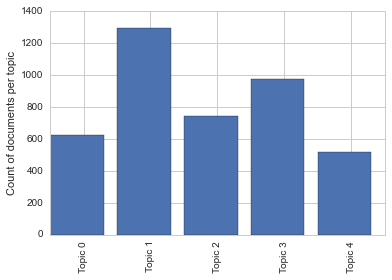

In [138]:
import seaborn as sns
import matplotlib.pyplot as plot
%matplotlib inline

def plotBarGraphOfDocumentsPerTopic(ldaColumnSum):
    sns.set_style("whitegrid")
    figure = plot.figure()
    subplot = figure.add_subplot(111)
    subplot.bar(np.arange(5), ldaColumnSum)
    subplot.set_ylabel("Count of documents per topic")
    subplot.set_xticklabels(["Topic {}".format(i) for i in range(5)], rotation = 90)
    subplot.set_xticks(np.arange(5) + 0.5)
    plot.show()

ldaColumnSum = np.sum(model.doc_topic_, axis = 0)
plotBarGraphOfDocumentsPerTopic(ldaColumnSum)

To complement the previous plot we also provide a heat chart that presents the numerical rating of each document per topic. We observe a well-differentiated collection of articles.

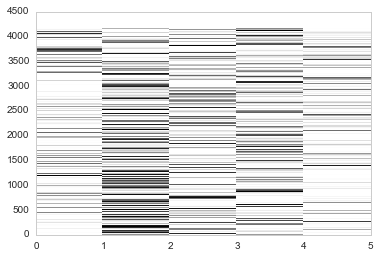

In [139]:
def plotHeatMapOfDocumentsPerTopic(documentsPerTopic):
    heatmap = plot.pcolor(documentsPerTopic)

plotHeatMapOfDocumentsPerTopic(model.doc_topic_)

To fully nail the analysis, below we present a word cloud for the different topics. Each word cloud contains the top words that represent each topic.

In [140]:
from wordcloud import WordCloud

def createTupleWordCountByTopic(wordRelativeFrequenciesByTopic, wordNames, modelCountsByTopic, topWordCount):
    tupleWordCountByTopic = [0] * len(wordRelativeFrequenciesByTopic[0])

    for index, topic in enumerate(wordRelativeFrequenciesByTopic):
        sortedTopic = np.argsort(topic)
        sortedModelCounts = list(modelCountsByTopic[sortedTopic][:-topWordCount:-1][:, index])
        sortedWords = list(wordNames[sortedTopic][:-topWordCount:-1])
        tupleWordCountByTopic[index] = list(zip(sortedWords, sortedModelCounts))
    
    return tupleWordCountByTopic

def createPlotTopWordsByTopicAndRelativeFrequency(wordRelativeFrequenciesByTopic, tupleWordCountByTopic, topWordCount):
    plots = []
    for index, topic in enumerate(wordRelativeFrequenciesByTopic):
        wordCloud = WordCloud(background_color = "white")
        wordCloudPlot = wordCloud.generate_from_frequencies(tupleWordCountByTopic[index])
        plots.append(wordCloudPlot)
        
    return plots

def displayPlots(plots):
    for p in plots:
        plot.imshow(p)
        plot.axis("off")
        plot.show()
    
def savePlots(plots, directory, fileNamePrefix):
    for index, p in enumerate(plots):
        plot.imshow(p)
        plot.axis("off")
        plot.savefig(directory + "/" + fileNamePrefix + str(index) + ".png")

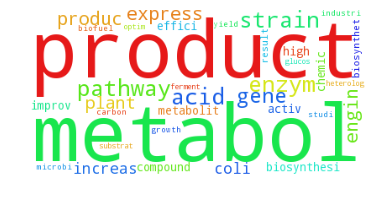

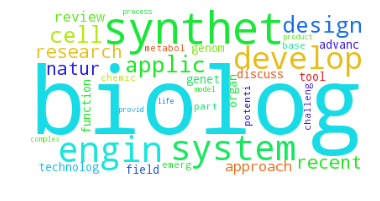

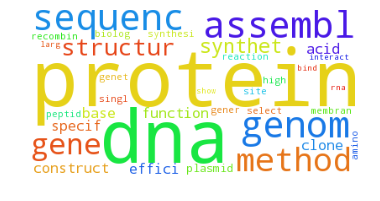

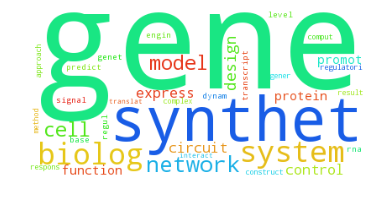

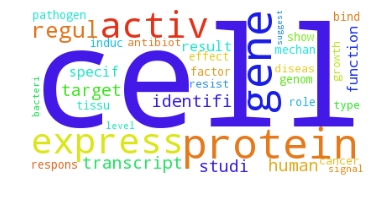

In [141]:
topWordCount = 36
modelCountsByTopic = np.array(model.nzw_).T
tupleWordCountByTopic = createTupleWordCountByTopic(model.topic_word_, wordNames, modelCountsByTopic, topWordCount)
plots = createPlotTopWordsByTopicAndRelativeFrequency(model.topic_word_, tupleWordCountByTopic, topWordCount)

directoryName = "Output"
fileNamePrefix = "synthetic_biology_topic"
savePlots(plots, directoryName, fileNamePrefix)
displayPlots(plots)

## Appendix I: Word clouds for each topic 

In [142]:
import matplotlib.image as mpimg

def readImage(filePath):
    image = mpimg.imread(filePath)
    return image

def plotImageFromFile(filePath):
    image = readImage(filePath)
    plot.axis("off")
    plot.imshow(image)
    plot.show()

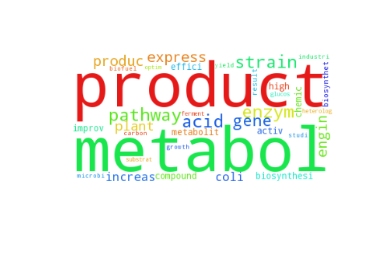

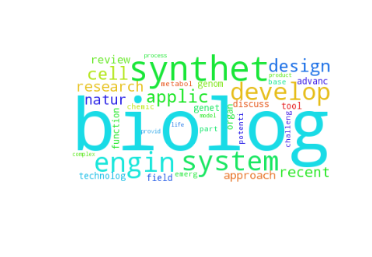

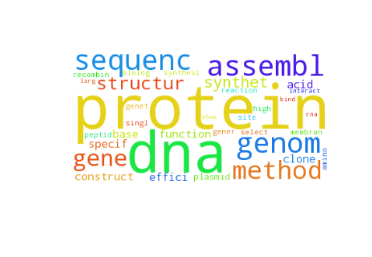

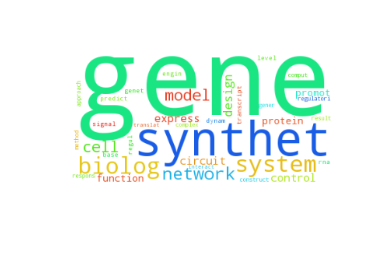

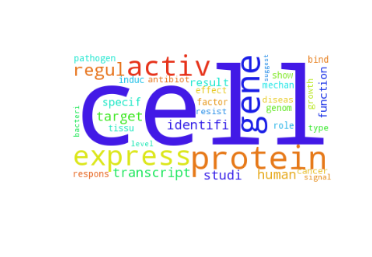

In [143]:
filePathFormatString = directoryName + "/" + fileNamePrefix + "{}.png"
filePaths = [filePathFormatString.format(index) for index in range(numberOfTopics)]
for filePath in filePaths:
    plotImageFromFile(filePath)

## Appendix II: Latent Semantic Indexing

In [144]:
from scipy.sparse.linalg import svds

def calculateSingularValueDecomposition(articlesAbstractWords, dimension = 300):
    articlesAbstractWordsMatrix = articlesAbstractWords.as_matrix()
    return svds(articlesAbstractWordsMatrix, k = dimension)

def createSVDDataFramesFromDocumentTermMatrix(articlesAbstractWords, dimension):
    factorIndex = []
    U, S, V = calculateSingularValueDecomposition(articlesAbstractWords, dimension)

    for index in range(count):
        factorIndex.append("Factor " + str(index))

    articleIdentifiers = list(articlesAbstractWords.index.values)
    words = list(articlesAbstractWords.columns.values)

    UDataFrame = pandas.DataFrame(U, index = articleIdentifiers, columns = factorIndex)
    SDataFrame = pandas.DataFrame(S, index = factorIndex)
    VTranspose = Vt.transpose()
    VTransposeDataFrame = pandas.DataFrame(VTranspose, index = words, columns = factorIndex)
    return UDataFrame, SDataFrame, VTransposeDataFrame

In [145]:
dimension = 200
with Timer() as timer:
    U, S, V = createSVDDataFramesFromDocumentTermMatrix(articlesAbstractWords, dimension)

print("SVD took " + str(timer.secs) + " s to execute for 200 dimensions")

SVD took 45.495383977890015 s to execute for 200 dimensions


In [146]:
U.to_pickle("Output/synthetic_biology_svd_u.pkl")
S.to_pickle("Output/synthetic_biology_svd_s.pkl")
V.to_pickle("Output/synthetic_biology_svd_v.pkl")

In [147]:
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize

def createQueryDataFrame(query, V):
    stemmer = PorterStemmer()
    queryDataFrame = pandas.DataFrame([])
    words = query.lower()
    words = word_tokenize(words)
    for word in words:
        word = stemmer.stem(word)
        wordFactors = V.ix[word]
        queryDataFrame = queryDataFrame.append(wordFactors, ignore_index = False)
    
    queryDataFrame = queryDataFrame.drop_duplicates()
    return queryDataFrame

def createQueryWordVectorFromDataFrame(weightArray, queryDataFrame):
    weightDataFrame = pandas.DataFrame(pandas.Series(weightArray, index = queryDataFrame.index.values))
    queryDataFrameTranspose = queryDataFrame.T
    wordVector = queryDataFrameTranspose.dot(weightDataFrame)
    return wordVector
    
def searchWords(weightArray, queryDataFrame, V):
    queryWordVector = createQueryWordVectorFromDataFrame(weightArray, queryDataFrame)
    words = V.dot(queryWordVector)
    words = words.sort([0], ascending = False)
    return words

def normalizeWeightArrayToVector(weightArray, queryDataFrame):
    queryWordVector = createQueryWordVectorFromDataFrame(weightArray, queryDataFrame)
    wordMatrix = queryWordVector.T.dot(queryWordVector)
    wordMatrix = wordMatrix.apply(np.sqrt)
    wordVector = queryWordVector.divide(wordMatrix[0], axis = 'columns')
    return wordVector

def searchDocuments(vector, U):
    documents = U.dot(vector)
    documents = documents.sort([0], ascending = False)
    return documents

In [148]:
# Create query data frame which contains words that will be used for search
query = "use uses using application useful commercialization disease basic fundamental research"
queryDataFrame = createQueryVector(query, V)
queryDataFrame.head(10)

,Factor 0,Factor 1,Factor 10,Factor 100,Factor 101,Factor 102,Factor 103,Factor 104,Factor 105,Factor 106,...,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99
use,-0.004237,-0.004255,0.003841,0.000957,0.000325,-0.001948,0.000680,0.002211,-0.003291,0.002012,...,0.001116,-0.002055,0.004492,0.004040,-0.004171,0.002023,0.003016,0.002722,0.003529,0.002300
applic,-0.001600,0.003474,-0.003137,0.001785,-0.002613,0.001461,-0.001670,0.000333,-0.000892,-0.000082,...,-0.002808,0.001513,-0.000965,0.000481,-0.000612,-0.000009,-0.002744,-0.000056,0.000346,0.000129
commerci,-0.000325,-0.000479,0.000139,0.000162,0.000004,-0.000188,0.000122,0.000218,-0.000088,0.000105,...,0.000002,0.000309,-0.000026,-0.000238,0.000085,0.000074,0.000490,0.000012,-0.000303,-0.000100
diseas,-0.000962,0.003414,-0.000421,0.000198,-0.003083,0.009542,0.000672,0.000611,0.007746,-0.000511,...,-0.006581,0.003154,0.005999,-0.008212,0.003001,-0.004434,-0.001276,-0.014007,-0.000423,0.010261
basic,-0.010561,-0.045212,0.006366,-0.030176,0.064089,-0.001746,0.019095,0.014314,-0.007662,-0.011532,...,-0.007015,-0.008827,-0.027969,-0.008856,0.062846,0.026350,0.003409,0.017299,-0.027357,0.001423
fundament,0.004974,0.002809,-0.000996,-0.002826,-0.004448,-0.001119,-0.000928,-0.011885,-0.008819,-0.006304,...,0.001381,0.003162,0.010847,0.015392,0.016859,0.008109,-0.003515,-0.033007,0.005820,-0.026785
research,-0.003023,0.000984,0.002699,-0.002698,0.001331,-0.000817,0.000673,0.001630,0.001595,0.000335,...,0.002310,0.000119,-0.000088,-0.001334,-0.000450,0.000467,0.002609,0.001320,-0.000592,0.001303


In [149]:
# Find words related to applied words
appliedWordWeights = [1, 1, 1, 0, -1, -1, -1]
similarWordsToApplied = searchWords(appliedWordWeights, queryDataFrame, V)
similarWordsToApplied.head(10)

,0
fluorin,0.023809
furaldehyd,0.023761
hydroxyhexano,0.020501
unsystemat,0.019398
mvd,0.018148
e186k,0.017442
bilater,0.017352
indirectli,0.015925
lomaiviticin,0.014509
k26d,0.014308


In [150]:
# Find documents which are applied and relevant to disease
diseaseWordWeights = [0, 0, 0, 1, 0, 0, 0]
diseaseVector = normalizeWeightArrayToVector(diseaseWordWeights, queryDataFrame)
appliedVector = normalizeWeightArrayToVector(appliedWordWeights, queryDataFrame)
appliedDiseaseVector = appliedVector + diseaseVector
appliedDiseaseDocuments = searchDocuments(appliedDiseaseVector, U)
print(corpus[appliedDiseaseDocuments.index[0]]["TI"])
print()
print(corpus[appliedDiseaseDocuments.index[0]]["AB"])

['A conjugate of octamer-binding transcription factor 4 and toll-like receptor 7', 'agonist prevents the growth and metastasis of testis embryonic carcinoma.']

['BACKGROUND: The immune non-recognition is often the underlying cause of failure', 'in tumor immunotherapeutic. This is because most tumor-related antigens are', 'poorly immunogenic, and fail to arouse an efficient immune response against', 'cancers. Here we synthesized a novel TLR7 agonist, and developed a safe and', 'effective immunotherapeutic vaccine by conjugating this TLR7 agonist with the', 'pluripotency antigen OCT4. METHODS: Purified recombinant OCT4 protein was', 'covalently linked with a novel TLR7 agonist to form a TLR7-OCT4 conjugate', '(T7-OCT4). After conjugation, the in vitro release of IL-12 and IFN-gamma was', 'observed in spleen lymphocytes. Mice were immunized with TLR7-OCT4, and the', 'release of IFN-gamma, the percentages of CD3+/CD8+ T cells and the OCT4-specific', 'cytotoxicity rates were measured. The 

## Appendix III: t-SNE Science Map of Synthetic Biology Documents

In [151]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plot
import numpy as np
from sklearn.manifold import TSNE

def tSNE(articlesAbstractWords): 
    articlesAbstractWords.sort(ascending = False)
    rowSum = articlesAbstractWords.sum(axis = 1)
    articlesAbstractWordsNormalized = articlesAbstractWords.div(rowSum, axis = 0)
    articlesAbstractWordsNormalized = articlesAbstractWordsNormalized.dropna()
    columnSum = articlesAbstractWords.sum(axis = 0)
    columnSum.sort(ascending = False)
    articlesAbstractWordsNormalizedSorted = articlesAbstractWords[columnSum.index]
    X = articlesAbstractWordsNormalized.as_matrix()
    model = TSNE(n_components = 2, random_state = 0, verbose = 1)
    positions = model.fit_transform(X)
    plot.scatter(positions[:, 0], positions[:, 1], s = 20, c = "b")
    plot.show()

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 4162
[t-SNE] Computed conditional probabilities for sample 2000 / 4162
[t-SNE] Computed conditional probabilities for sample 3000 / 4162
[t-SNE] Computed conditional probabilities for sample 4000 / 4162
[t-SNE] Computed conditional probabilities for sample 4162 / 4162
[t-SNE] Mean sigma: 0.033996
[t-SNE] Error after 65 iterations with early exaggeration: 26.809618
[t-SNE] Error after 157 iterations: 3.256353


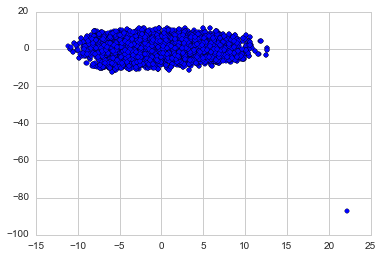

tSNE took 153.5077941417694 s to execute for full data


In [152]:
with Timer() as timer:
    tSNE(articlesAbstractWords)

print("tSNE took " + str(timer.secs) + " s to execute for full data")